## About this notebook
This notebook has the experients done in **Uncovering differential equations from data with hidden variables** when some variables of the system are not observed. We analyze the oscilator, Rossler and Lorenz Attractor system when only one variable is observed. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import warnings

In [3]:
notebooks_dir = get_ipython().starting_dir
sys.path.append(os.path.join(notebooks_dir, '..', '.'))

In [5]:
from src.scripts.ode.generate_data import generate_data, generate_data_with_noise
from src.lib.simulation_manager import Oscilator, LorenzAttractor, RoselerAttractor
from src.scripts.ode.fit_odefind import fit_and_save_coeffs
from src.scripts.config import data_path, results_path
from src.scripts.ode.integrate_predict import integrate_predict_smape
from src.scripts.ode.plot_predictions import plot_predictions , plot_times
from src.scripts.ode.mse_time_comparison import compare_coeffs, plot_mse_time, plot_coeffs
from utils.utils import print_discovered_equation, print_discovered_equation_v2
from utils.utils import visualize_noise_impact

## Generate data

In [6]:
gen_data = [['LorenzAttractor', LorenzAttractor,[{'sigma': 10, 'rho': 28, 'beta': 8.0 / 3}]],
            ['rosseler', RoselerAttractor,[{'a': 0.52, 'b': 2, 'c': 4}]],
            ['oscilator',Oscilator,[{'a': 0.1, 'b': -1, 'c': 1, 'd': 0}] ]
           ]
for data_experiment_name, model_class, list_model_parms in gen_data:
    
    folder_data = generate_data(
                    num_experiments_per_param=20,
                    num_time_steps=5000,
                    dt=0.01,

                    data_experiment_name=data_experiment_name,
                    model_class=model_class,
                    list_model_params=list_model_parms
                )
    print(f'Data was saved in {folder_data}')

Data was saved in /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/LorenzAttractor
Data was saved in /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/rosseler
Data was saved in /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/oscilator


## Experiments setting
Select the system.

In [6]:
gpomo_steps = 40 # fast run 
# gpomo_steps = 5120 # paper results

In [7]:
# # Oscilator with x as observed variable
system = 'oscilator'
obs_vars = ['x']
targets = [1, 2]
maxpolys = [3]
targets_to_plot = [1,2]

In [7]:
# # Rossler with x as observed variable
# system = 'rosseler'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [8]:
# # Rossler with y as observed variable
# system = 'rosseler'
# obs_vars = ['y']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [9]:
# # Lorenz Attractor with x as observed variable
# system = 'LorenzAttractor'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [10]:
# Temperature data set
# system = 'temperatures'
# obs_vars = ['x']
# targets = [2, 3]
# maxpolys = [3]
# targets_to_plot = targets

## Fit L-ODEfind models

In [10]:
%%time
model = system
out = system
warnings.filterwarnings("ignore")
fit_and_save_coeffs(model, out, targets=targets, maxpolys=maxpolys, obs_vars=obs_vars, testsize=200)


CPU times: user 53.7 s, sys: 2min 13s, total: 3min 7s
Wall time: 19.6 s


## Fit GPoMo models
We use R to fit GPoMo models. The library GPoM needs to be installed.

In [8]:
d_path = str(data_path.resolve()) + f'/{system}/'
r_path = str(results_path.resolve()) + f"/{system}_{'_'.join(obs_vars)}/"
v = '_'.join(obs_vars)

In [9]:
%%time
%cd ..
%cd r_scripts
! Rscript gpomo_predition_1_var_observed.R $d_path $r_path $v $gpomo_steps

/Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind
/Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/r_scripts
Le chargement a nécessité le package : GPoM
Le chargement a nécessité le package : deSolve
Le chargement a nécessité le package : rgl
This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).
[1] "/Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/data/oscilator/"
[1] "/Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/results/oscilator_x/"
[1] "x"
[1] "40"
[1] "/Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/data/oscilator/"
[1] "--------------------------"
[1] "solution_params_0_init_cond_0.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10

### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.05s 

### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0m

## Integrate, predict and compute SMAPE for L-ODEfind and GPoMo models

In [13]:
#%%time
odefind_model = f"{system}_{'_'.join(obs_vars)}_Odefind"
gpomo_model = f"{system}_{'_'.join(obs_vars)}"
for model_data, model_results in [[system,gpomo_model],[system, odefind_model]]:
# for model_data, model_results in [[system, odefind_model]]:
    df = integrate_predict_smape(original_data=model_data, results_folder=model_results,
                             time_horizons=np.arange(1, 200, dtype=int),
                             testsize=200, one=False, verbose=True)


solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_10-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_4-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_17-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_3-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_10-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_17-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_2-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_16-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_5-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_11-steps_40.csv


## Plot predictions comparison

System:oscilator with observed variables ['x']


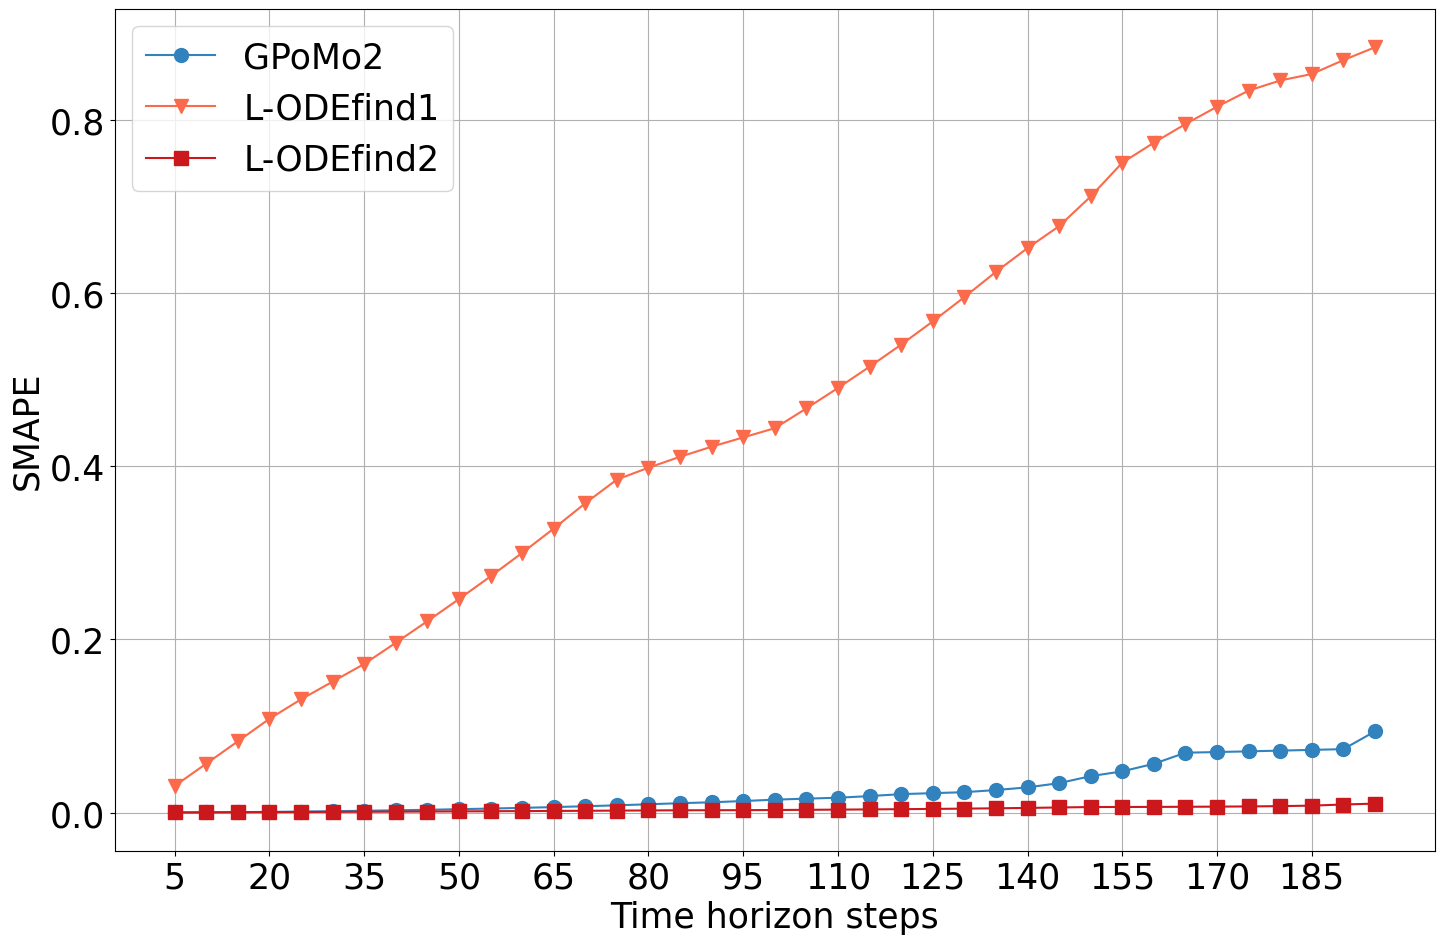

In [16]:
print(f'System:{system} with observed variables {obs_vars}')
# gpomo_model = False
plot_data = plot_predictions(path_gpomo = gpomo_model,
                             time_horizons = np.arange(5, 196, 5), 
                             path_pdefind = odefind_model, 
                             ymax = None, 
                             targets_to_plot = targets_to_plot)


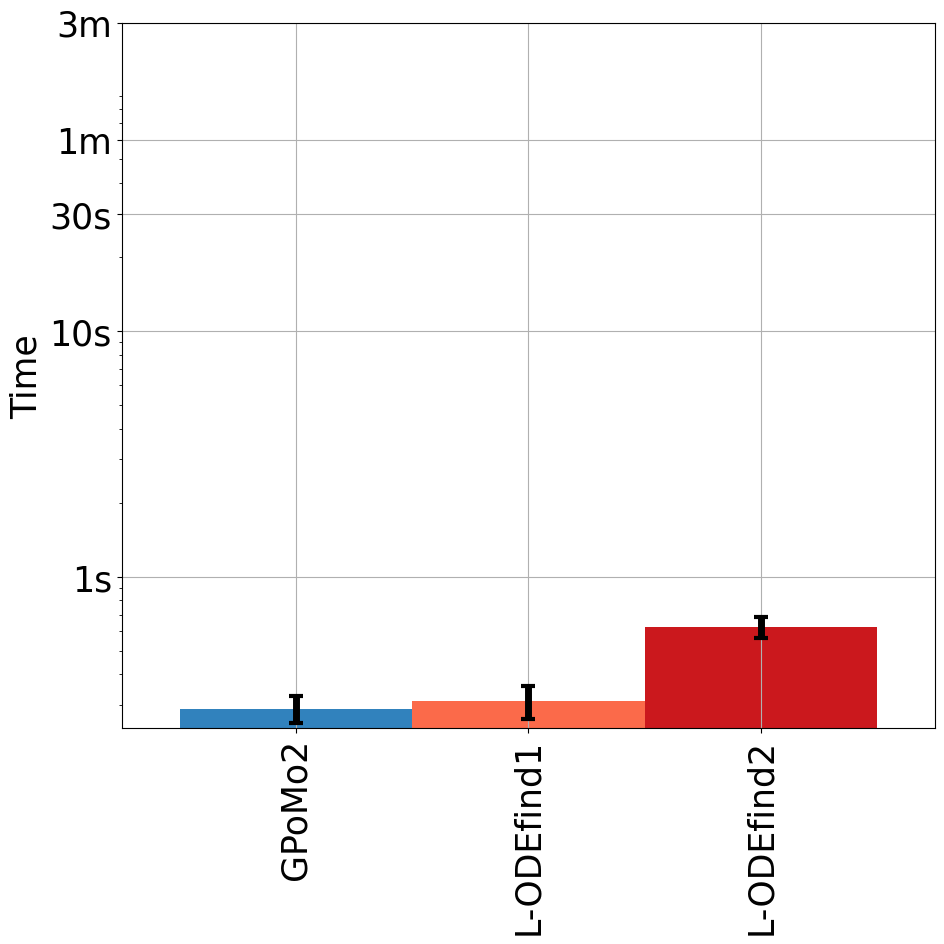

In [17]:
times_data = plot_times(gpomo_model, odefind_model,targets_to_plot=targets_to_plot)

## Analysis of the coefficients.
In the case of the oscilator (observed variable x) and Rossler (observed variable), it is possible to reconstruct a trajectory (equivalent to the original one) given only one of the model variables. In these system, we can compare the MSE between the true coefficients and the ones found by the algorithm. 

In [18]:
system = 'oscilator'
obs_vars = ['x']
var_name = 'X'
d = 2
fully_obs = False

In [18]:
# system = 'rosseler'
# obs_vars = ['y']
# var_name = 'Y'
# d = 3
# fully_obs = False

System: oscilator (observed variable ['x'])


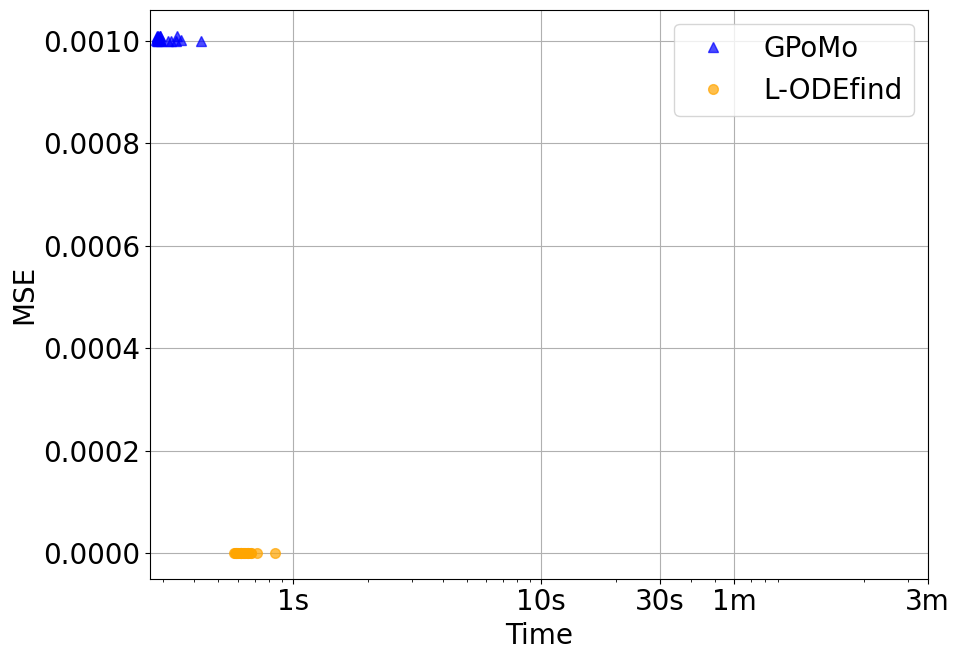

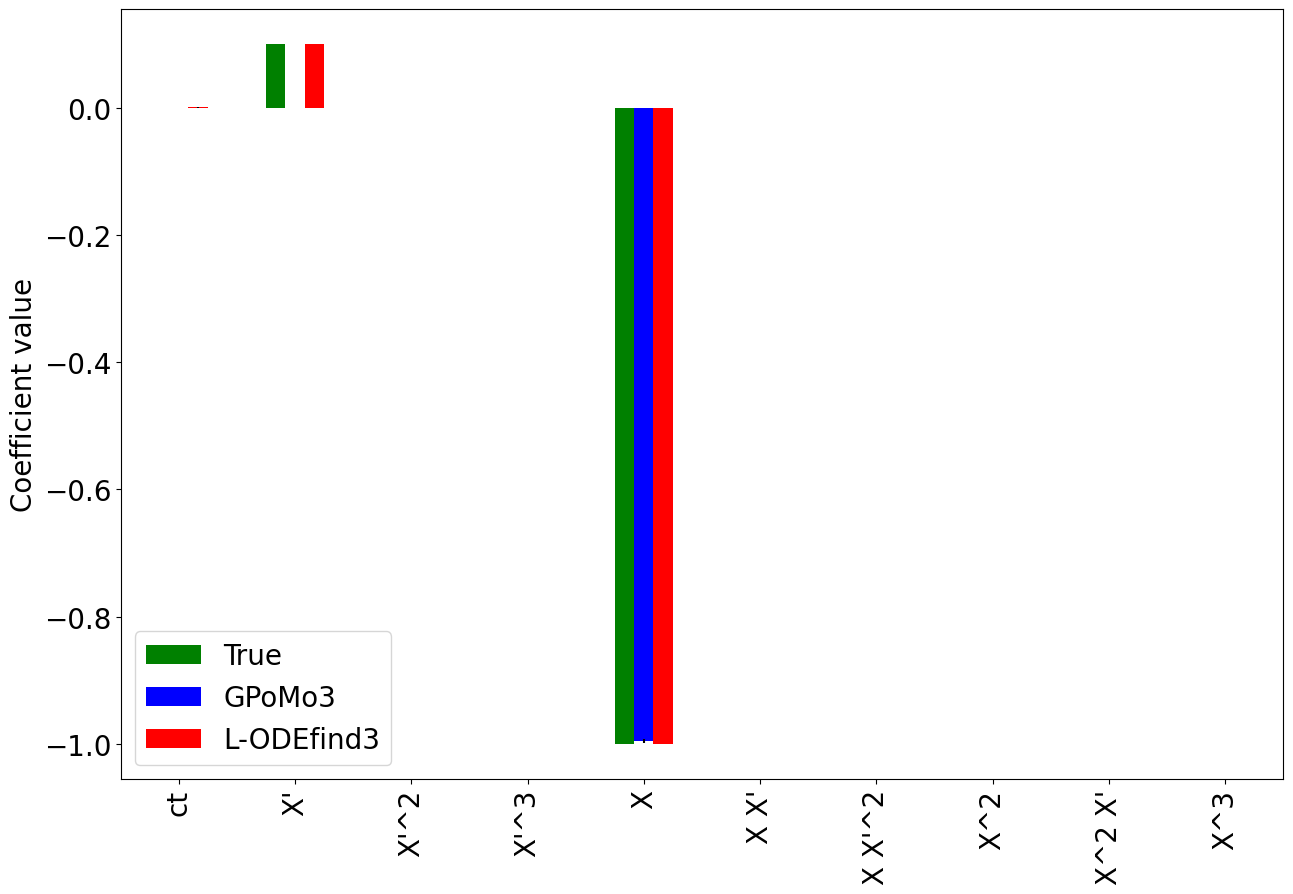

In [19]:
df_mse_gpomo, coeffs_gpomo = compare_coeffs(original_data=system, results_folder=system+'_'+'_'.join(obs_vars),
                                            var_name=var_name,
                                            d=d, fully_obs=fully_obs)
df_mse_odefind, coeffs_odefind = compare_coeffs(original_data=system, results_folder=system+'_'+'_'.join(obs_vars) + '_Odefind',
                                                var_name=var_name, d=d, fully_obs=fully_obs)

plot_mse_time(pd.concat([df_mse_gpomo, df_mse_odefind]), system+'_'+'_'.join(obs_vars))
# plot_mse_time(df_mse_odefind, system+'_'+'_'.join(obs_vars))


if not fully_obs:
    coeffs = pd.concat([coeffs_gpomo, coeffs_odefind], axis=1)
    # coeffs = coeffs_odefind
    coeffs = coeffs.loc[:, ~coeffs.columns.duplicated()]
    plot_coeffs(coeffs, system+'_'+'_'.join(obs_vars), var_name, d)
    
print(f'System: {system} (observed variable {obs_vars})')
    

## Show the founded coefficients

In [21]:
results_path = 'results' 
system_name = "oscilator"

print_discovered_equation_v2(
    results_dir=results_path,
    system_name=system_name,   # Note the spelling used in the repo filenames
    obs_vars=['x'],
    target_d=2,                # The dmax you set (target derivative)
    max_poly=3,
    params_id=0,
    init_cond_id=5
)

### Ok, now it works quite well that is nice 

--- Discovered Equation for oscilator (observed: x) ---
d^2x/dt^2 = 0.0002 - 0.9997 x + 0.0997 dx/dt + 0.0000 x dx/dt
------------------------------------------------------------


# Experiments with noise

Generated 1 files in: /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/temp_viz_clean_noise_0.0
Generated 1 files in: /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/temp_viz_noise_0.0_SNR_noise_0.0
Generated 1 files in: /Users/benpro/Documents/PHD/code/AISTAT26/L-ODEfind/examples/../data/temp_viz_noise_0.05_SNR_noise_0.05


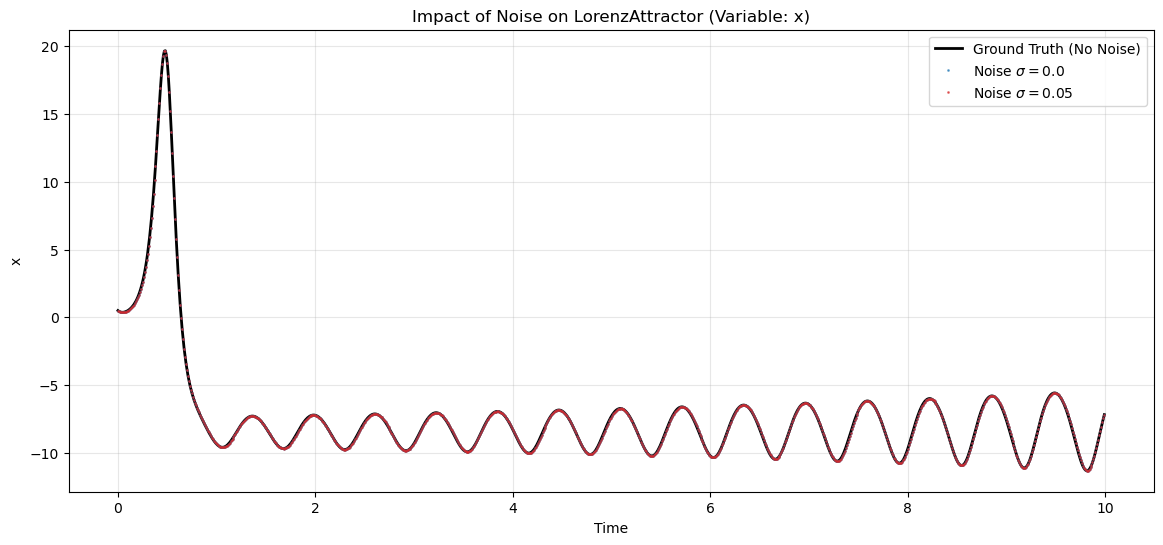

In [123]:
# --- Example Usage: Visualize Lorenz Attractor with Noise ---
# params for Lorenz: sigma=10, rho=28, beta=8/3
noise_type = "SNR"
visualize_noise_impact(
    system_class=LorenzAttractor, 
    params={'sigma': 10, 'rho': 28, 'beta': 8.0/3}, 
    variable='x', 
    noise_levels=[0.0, 0.05],
    noise_type = noise_type
)

## Small experiments: visualisation of the effect of noise on the estimation of the derivatives 

In [127]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from functools import partial 

noise_levels = [0.0, 0.05]
data = {}
finite_diff = True

path_local = os.getcwd()
path_csv = path_local[:-(len(path_local.split('/')[-1])+ 1)]
for noise_level in noise_levels:

    if noise_type == 'SNR':
        name_folder = f'temp_viz_noise_{noise_level}_{noise_type}_noise_{noise_level}'
    else:
        name_folder = f'temp_viz_noise_{noise_level}_noise_{noise_level}'
    if noise_level == 0:
        name_folder = 'temp_viz_clean_noise_0.0'
    data_noisy = pd.read_csv(os.path.join(path_csv, 'data', name_folder, 'solution_params_0_init_cond_0.csv'))
    data[noise_level] = data_noisy

In [ ]:
### parameters for the Savitzky-Golay method 

window_length, poly_order = 11, 3 
t = data[noise_levels[0]]['time'].to_numpy()
data_x, data_dx, data_dx2 = {}, {}, {}

if finite_diff:
    diff_op = np.gradient 
else: #Savitzky-Golay
    diff_op = partial(savgol_filter, window_length = window_length, polyorder = poly_order) 


for noise_level in noise_levels: 
    if finite_diff:
        diff_op = np.gradient 
        data_x[noise_level] = data[noise_level]['x'].to_numpy()
        data_dx[noise_level] = diff_op(data_x[noise_level])
        data_dx2[noise_level] = diff_op(data_dx[noise_level])

    else: #Savitzky-Golay
        diff_op = partial(savgol_filter, window_length = window_length, polyorder = poly_order) 
        data_x[noise_level] = data[noise_level]['x'].to_numpy()
        data_dx[noise_level] = diff_op(data_x[noise_level], deriv=1)
        data_dx2[noise_level] = diff_op(data_dx[noise_level], deriv=2)

if len(noise_levels) > 1:
    print('the noise is that powerful:', np.max(np.max((data_x[0.0] - data_x[noise_levels[1]])) / np.max(np.abs(data_x[0.0]))))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize = (10,8))
for noise_level in noise_levels:

    label = f'Noise: {noise_level}'
    ax1.plot(t,data_x[noise_level], label = label)
    ax2.plot(t,data_dx[noise_level], label = label)
    ax3.plot(t,data_dx2[noise_level], label = label)

ax1.set_title('x')
ax2.set_title('dx')
ax3.set_title('dx2')

ax1.legend()
ax2.legend()
ax3.legend()

fig.set_tight_layout(tight=True)
fig.suptitle('Effect of Noise on the Estimation of the Gradients')
plt.show()
# ax2.set_ylim(-1,1)

TypeError: gradient() got an unexpected keyword argument 'deriv'

In [120]:
### Compute the mean square error 

### how to make it clean, without using AI 

for noise_level in noise_levels[1:]:

    mean_x = np.mean((data_x[noise_level] - data_x[0.0])**2) / np.mean(data_x[0.0]**2)
    mean_dx = np.mean((data_dx[noise_level] - data_dx[0.0])**2) / np.mean(data_dx[0.0]**2)
    mean_dx2 = np.mean((data_dx2[noise_level] - data_dx2[0.0])**2) / np.mean(data_dx2[0.0]**2)

    print(f'The mse for x is {mean_x}\n')
    print(f'The mse for dx is {mean_dx}\n')
    print(f'The mse for dx2 is {mean_dx2}\n')

The mse for x is 0.0005256409960909791

The mse for dx is 0.03891954599907442

The mse for dx2 is 1.1162298072679913

